In [ ]:
import os
import random
import torch
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import lovely_tensors as lt
lt.monkey_patch()

from csng.utils.data import crop
from csng.data import get_dataloaders, get_sample_data
from csng.models.readins import MEIReadIn
from csng.utils.mix import seed_all, update_config_paths, update_config_keys_to_value, plot_comparison
from csng.models.utils.gan import init_decoder as init_gan_decoder
from csng.models.utils.cnn import init_decoder as init_cnn_decoder
from csng.models.utils.gan import train
from csng.utils.comparison import eval_decoder
from csng.losses import get_metrics
from csng.brainreader_mouse.encoder import get_encoder as get_encoder_brainreader
from csng.mouse_v1.encoder import get_encoder as get_encoder_sensorium_mouse_v1
from csng.cat_v1.encoder import get_encoder as get_encoder_cat_v1
from csng.brainreader_mouse.data import get_brainreader_mouse_dataloaders

### set paths
DATA_PATH = os.environ["DATA_PATH"]
DATA_PATH_CAT_V1 = os.path.join(DATA_PATH, "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(DATA_PATH, "mouse_v1_sensorium22")
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, "brainreader")
print(f"{DATA_PATH=}\n{DATA_PATH_CAT_V1=}\n{DATA_PATH_MOUSE_V1=}\n{DATA_PATH_BRAINREADER=}")

!nvidia-smi

DATA_PATH='/media/jan/ext_ssd/csng_data'
DATA_PATH_CAT_V1='/media/jan/ext_ssd/csng_data/cat_V1_spiking_model/50K_single_trial_dataset'
DATA_PATH_MOUSE_V1='/media/jan/ext_ssd/csng_data/mouse_v1_sensorium22'
DATA_PATH_BRAINREADER='/media/jan/ext_ssd/csng_data/brainreader'
Mon Jul 28 13:00:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.169                Driver Version: 570.169        CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   0000000

## Collect encoder responses

In [ ]:
### setup config
cfg = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "save_path": os.path.join(DATA_PATH, "models", "encoder_b6.pt"),
    "data": dict(),
}

### brainreader mouse data
cfg["data"]["brainreader_mouse"] = {
    "device": cfg["device"],
    "mixing_strategy": "sequential",
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": 128,
    "sessions": [6],
    "resize_stim_to": (36, 64),
    "normalize_stim": True,
    "normalize_resp": False,
    "div_resp_by_std": True,
    "clamp_neg_resp": False,
    "additional_keys": None,
    "avg_test_resp": True,
    "train_datapoint_idxs_to_use": None,
    # "train_datapoint_idxs_to_use": np.random.default_rng(seed=cfg["seed"]).choice(4500, size=2000, replace=False),
}

In [ ]:
# Load encoder
encoder = get_encoder_brainreader(
    os.path.join(DATA_PATH, "models", "encoders", "encoder_b6.pt"),
    device=cfg["device"],
)

[INFO] Loading encoder checkpoint from /media/jan/ext_ssd/csng_data/models/encoders/encoder_b6.pt


/home/jan/Desktop/Dev/csng/decoding-brain-activity/pkgs/neuralpredictors/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/home/jan/Desktop/Dev/csng/decoding-brain-activity/pkgs/neuralpredictors/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


In [25]:
# Collect responses
dls = get_brainreader_mouse_dataloaders(config=cfg["data"]["brainreader_mouse"])["brainreader_mouse"]

stim_all, resp_all, resp_pred_all = [], [], []
for dp in dls["train"]:
    assert len(dp) == 1
    stim = dp[0]["stim"].to(cfg["device"])
    data_key, neuron_coords, pupil_center = dp[0]["data_key"], dp[0]["neuron_coords"], dp[0]["pupil_center"]
    if neuron_coords is not None:
        neuron_coords = neuron_coords.to(cfg["device"])
    if pupil_center is not None:
        pupil_center = pupil_center.to(cfg["device"])

    # Get encoder responses
    enc_resp = encoder(
        stim,
        data_key=data_key,
        neuron_coords=neuron_coords,
        pupil_center=pupil_center,
    ) # (B, n_neurons)

    # Save
    stim_all.append(stim.cpu().detach())
    resp_all.append(dp[0]["resp"].cpu().detach())
    resp_pred_all.append(enc_resp.cpu().detach())

# Save responses to file
stim_all = torch.cat(stim_all, dim=0)  # (N, C, H, W)
resp_all = torch.cat(resp_all, dim=0)  # (N, n_neurons)
resp_pred_all = torch.cat(resp_pred_all, dim=0)  # (N, n_neurons)
print(f"Collected {resp_all.shape[0]} responses with shape {resp_all.shape}.")
torch.save({"stim_all": stim_all, "resp_all": resp_all, "resp_pred_all": resp_pred_all, "config": cfg}, "encoder_responses.pt")

Collected 4500 responses with shape torch.Size([4500, 8587]).


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [30]:
# Model definition
class LinearizedEncoder(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(input_features, output_features)

    def forward(self, x):
        # x shape: (B, C, H, W)
        x_flat = self.flatten(x) # shape: (B, C*H*W)
        return self.linear(x_flat) # shape: (B, output_features)

In [60]:
# Hyperparameters
cfg["linear"] = {
    "data_path": "encoder_responses.pt",
    "batch_size": 256,
    "learning_rate": 3e-3,
    "weight_decay": 1e-4,
    "epochs": 30,
    "val_split": 0.1,
}

In [61]:
# Data
seed_all(cfg["seed"])
data = torch.load(cfg["linear"]["data_path"], map_location="cpu")
X, y = data["stim_all"], data["resp_pred_all"]

print(f"Stimulus shape (X): {X.shape}")
print(f"Target response shape (y): {y.shape}")

# Create a dataset and dataloaders
dataset = TensorDataset(X, y)

# Split into training and validation sets
val_size = int(len(dataset) * cfg["linear"]["val_split"])
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=cfg["linear"]["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=cfg["linear"]["batch_size"], shuffle=False)
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Stimulus shape (X): torch.Size([4500, 1, 36, 64])
Target response shape (y): torch.Size([4500, 8587])
Training set size: 4050
Validation set size: 450


In [62]:
# Model
_, C, H, W = X.shape
_, n_neurons = y.shape
input_features = C * H * W

model = LinearizedEncoder(input_features, n_neurons).to(cfg["device"])
print(f"\nInitialized Linear model with {input_features} input features and {n_neurons} output features.")

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=cfg["linear"]["learning_rate"], weight_decay=cfg["linear"]["weight_decay"])


Initialized Linear model with 2304 input features and 8587 output features.


In [63]:
# --- Step 4: Training and Validation Loop ---
print("\nStarting training...")
history = {"train_loss": [], "val_loss": [], "val_r2": []}
for epoch in range(cfg["linear"]["epochs"]):
    # Training phase
    model.train()
    total_train_loss = 0
    for stim_batch, resp_batch in train_loader:
        stim_batch, resp_batch = stim_batch.to(cfg["device"]), resp_batch.to(cfg["device"])

        optimizer.zero_grad()
        predictions = model(stim_batch)
        loss = criterion(predictions, resp_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)

    # Validation phase
    model.eval()
    total_val_loss = 0
    all_targets = []
    all_preds = []
    with torch.no_grad():
        for stim_batch, resp_batch in val_loader:
            stim_batch, resp_batch = stim_batch.to(cfg["device"]), resp_batch.to(cfg["device"])
            predictions = model(stim_batch)
            loss = criterion(predictions, resp_batch)
            total_val_loss += loss.item()
            
            all_targets.append(resp_batch.cpu().numpy())
            all_preds.append(predictions.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    history["val_loss"].append(avg_val_loss)

    # Calculate R-squared score for the entire validation set
    all_targets = np.concatenate(all_targets, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    # Calculate R2 per neuron and average. This is a robust metric.
    r2 = r2_score(all_targets, all_preds, multioutput='variance_weighted')
    history["val_r2"].append(r2)

    print(f"Epoch {epoch+1}/{cfg['linear']['epochs']} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | Val R²: {r2:.4f}")


Starting training...
Epoch 1/30 | Train Loss: 3.315087 | Val Loss: 0.929637 | Val R²: -7.4015
Epoch 2/30 | Train Loss: 0.760255 | Val Loss: 0.423067 | Val R²: -2.8199
Epoch 3/30 | Train Loss: 0.334910 | Val Loss: 0.256699 | Val R²: -1.3216
Epoch 4/30 | Train Loss: 0.221285 | Val Loss: 0.207657 | Val R²: -0.8780
Epoch 5/30 | Train Loss: 0.176995 | Val Loss: 0.176977 | Val R²: -0.6005
Epoch 6/30 | Train Loss: 0.153275 | Val Loss: 0.159333 | Val R²: -0.4411
Epoch 7/30 | Train Loss: 0.136395 | Val Loss: 0.146570 | Val R²: -0.3261
Epoch 8/30 | Train Loss: 0.124024 | Val Loss: 0.134278 | Val R²: -0.2145
Epoch 9/30 | Train Loss: 0.114120 | Val Loss: 0.128510 | Val R²: -0.1624
Epoch 10/30 | Train Loss: 0.107817 | Val Loss: 0.123678 | Val R²: -0.1177
Epoch 11/30 | Train Loss: 0.102305 | Val Loss: 0.118186 | Val R²: -0.0685
Epoch 12/30 | Train Loss: 0.097122 | Val Loss: 0.115990 | Val R²: -0.0488
Epoch 13/30 | Train Loss: 0.094016 | Val Loss: 0.112903 | Val R²: -0.0210
Epoch 14/30 | Train Loss:


Training complete.


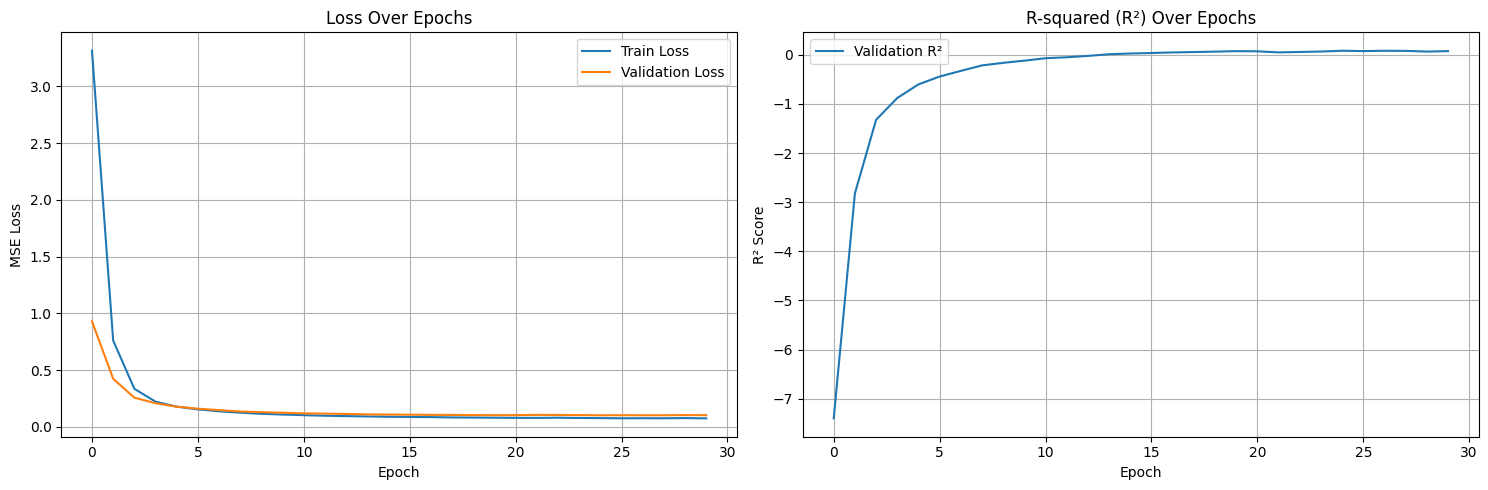

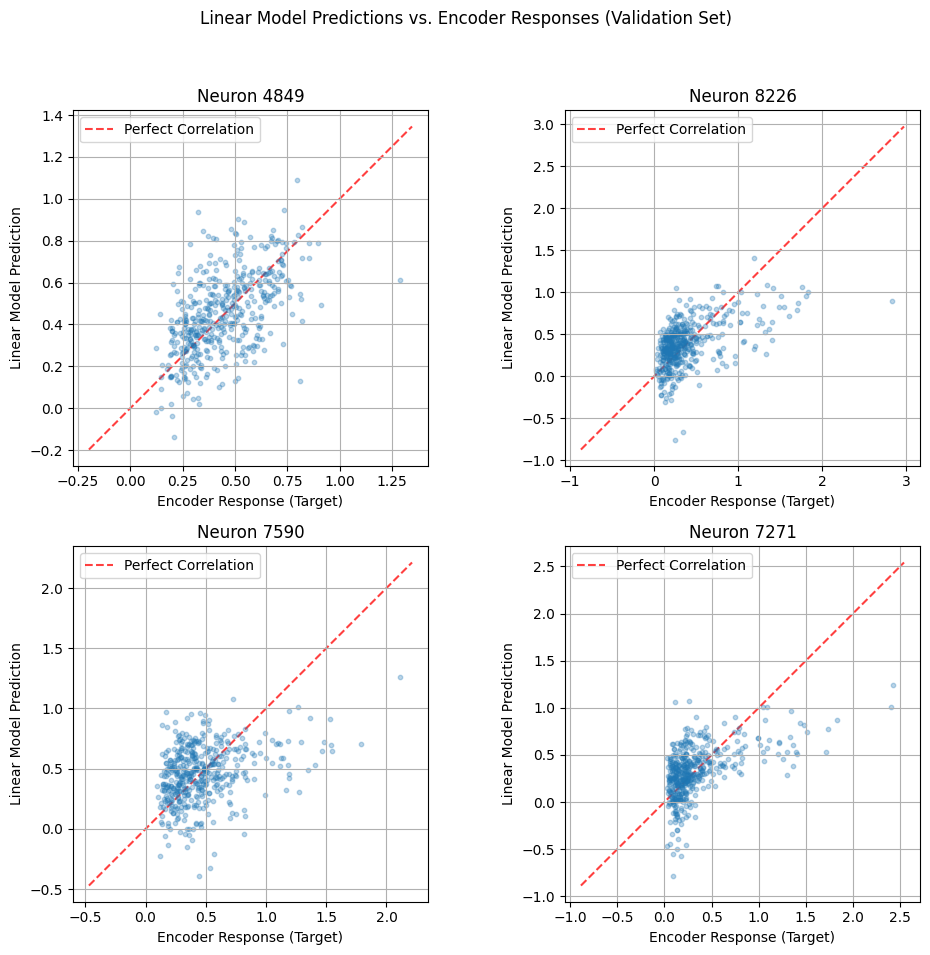

In [64]:
# --- Step 5: Final Evaluation and Visualization ---
print("\nTraining complete.")

# Plotting training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history["train_loss"], label="Train Loss")
ax1.plot(history["val_loss"], label="Validation Loss")
ax1.set_title("Loss Over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE Loss")
ax1.legend()
ax1.grid(True)

ax2.plot(history["val_r2"], label="Validation R²")
ax2.set_title("R-squared (R²) Over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("R² Score")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Visualize predictions vs. actuals for a few example neurons
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for i, neuron_idx in enumerate(np.random.choice(n_neurons, 4, replace=False)):
    ax = axes[i]
    ax.scatter(all_targets[:, neuron_idx], all_preds[:, neuron_idx], alpha=0.3, s=10)
    # Plot a perfect correlation line
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1]),
    ]
    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label="Perfect Correlation")
    ax.set_xlabel("Encoder Response (Target)")
    ax.set_ylabel("Linear Model Prediction")
    ax.set_title(f"Neuron {neuron_idx}")
    ax.legend()
    ax.grid(True)
    ax.set_aspect('equal', adjustable='box')

fig.suptitle("Linear Model Predictions vs. Encoder Responses (Validation Set)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [65]:
# Compute correlation on a separate test set
dls = get_brainreader_mouse_dataloaders(config=cfg["data"]["brainreader_mouse"])["brainreader_mouse"]

resp_all, resp_encoder, resp_linear = [], [], []
for dp in dls["val"]:
    assert len(dp) == 1
    stim = dp[0]["stim"].to(cfg["device"])
    data_key, neuron_coords, pupil_center = dp[0]["data_key"], dp[0]["neuron_coords"], dp[0]["pupil_center"]
    if neuron_coords is not None:
        neuron_coords = neuron_coords.to(cfg["device"])
    if pupil_center is not None:
        pupil_center = pupil_center.to(cfg["device"])

    # Get encoder responses
    enc_resp = encoder(
        stim,
        data_key=data_key,
        neuron_coords=neuron_coords,
        pupil_center=pupil_center,
    ) # (B, n_neurons)

    # Get linear model predictions
    linear_resp = model(stim)  # (B, n_neurons)

    # Save
    resp_all.append(dp[0]["resp"].cpu().detach())
    resp_encoder.append(enc_resp.cpu().detach())
    resp_linear.append(linear_resp.cpu().detach())

resp_all = torch.cat(resp_all, dim=0)  # (N, n_neurons)
resp_encoder = torch.cat(resp_encoder, dim=0)  # (N, n_neurons)
resp_linear = torch.cat(resp_linear, dim=0)  # (N, n_neurons)
print(f"Collected {resp_all.shape[0]} responses with shape {resp_all.shape}.")
print(f"Encoder responses shape: {resp_encoder.shape}")
print(f"Linear model predictions shape: {resp_linear.shape}")

Collected 500 responses with shape torch.Size([500, 8587]).
Encoder responses shape: torch.Size([500, 8587])
Linear model predictions shape: torch.Size([500, 8587])


In [71]:
# Compute correlation
resp_encoder_np = resp_encoder.cpu().numpy()
resp_linear_np = resp_linear.cpu().numpy()
resp_gt = resp_all.cpu().numpy()
n_neurons = resp_encoder_np.shape[1]

# List to store the correlation for each neuron
per_neuron_corr = []
per_neuron_encoder_to_gt_corr = []
per_neuron_linear_to_gt_corr = []

# Loop over each neuron to compute correlation individually
for i in range(n_neurons):
    # Get predictions for the i-th neuron
    encoder_preds_neuron_i = resp_encoder_np[:, i]
    linear_preds_neuron_i = resp_linear_np[:, i]
    gt_neuron_i = resp_gt[:, i]
    
    # Calculate the Pearson correlation coefficient
    corr = np.corrcoef(encoder_preds_neuron_i, linear_preds_neuron_i)[0, 1]
    corr_encoder_to_gt = np.corrcoef(encoder_preds_neuron_i, gt_neuron_i)[0, 1]
    corr_linear_to_gt = np.corrcoef(linear_preds_neuron_i, gt_neuron_i)[0, 1]
    
    # Check for NaN values (can happen if a neuron's output is constant)
    if not np.isnan(corr):
        per_neuron_corr.append(corr)
    if not np.isnan(corr_encoder_to_gt):
        per_neuron_encoder_to_gt_corr.append(corr_encoder_to_gt)
    if not np.isnan(corr_linear_to_gt):
        per_neuron_linear_to_gt_corr.append(corr_linear_to_gt)

per_neuron_corr = np.array(per_neuron_corr)
per_neuron_encoder_to_gt_corr = np.array(per_neuron_encoder_to_gt_corr)
per_neuron_linear_to_gt_corr = np.array(per_neuron_linear_to_gt_corr)

Correlation Analysis: Linear Model vs. Encoder
Number of neurons analyzed: 8587
Mean Correlation:   0.4226
Median Correlation: 0.4302
Std Dev of Corrs:   0.1288
Percentage of neurons with correlation > 0.95: 0.00%


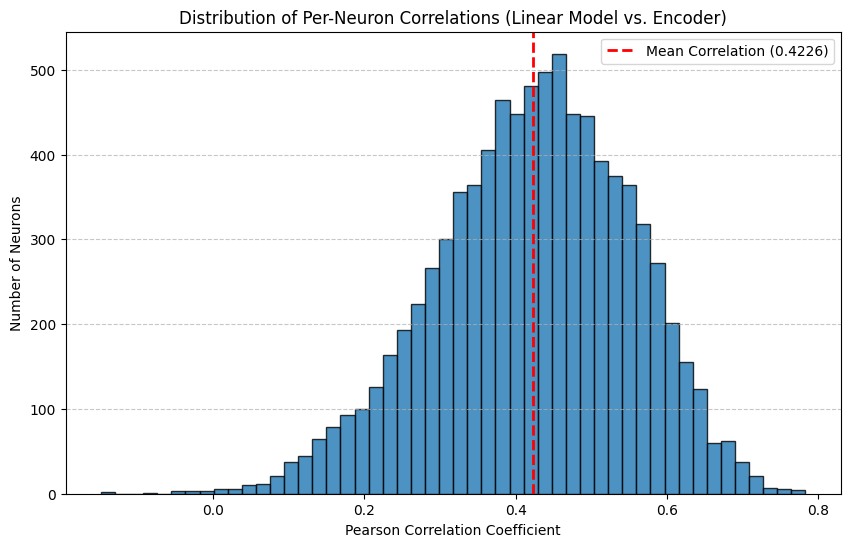

In [72]:
# --- Step 3: Report and Visualize Results ---
print("Correlation Analysis: Linear Model vs. Encoder")
print(f"Number of neurons analyzed: {len(per_neuron_corr)}")

# Print summary statistics
mean_corr = np.mean(per_neuron_corr)
median_corr = np.median(per_neuron_corr)
std_corr = np.std(per_neuron_corr)

print(f"Mean Correlation:   {mean_corr:.4f}")
print(f"Median Correlation: {median_corr:.4f}")
print(f"Std Dev of Corrs:   {std_corr:.4f}")

# Print percentage of neurons above a certain threshold
high_corr_threshold = 0.95
num_high_corr_neurons = np.sum(per_neuron_corr > high_corr_threshold)
percent_high_corr = (num_high_corr_neurons / len(per_neuron_corr)) * 100
print(f"Percentage of neurons with correlation > {high_corr_threshold}: {percent_high_corr:.2f}%")


# Visualize the distribution of correlations
plt.figure(figsize=(10, 6))
plt.hist(per_neuron_corr, bins=50, alpha=0.8, edgecolor='black')
plt.axvline(mean_corr, color='r', linestyle='--', linewidth=2, label=f'Mean Correlation ({mean_corr:.4f})')
plt.title('Distribution of Per-Neuron Correlations (Linear Model vs. Encoder)')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Number of Neurons')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [97]:
# Compute Non-Linearity Index (NLI)
nli = per_neuron_encoder_to_gt_corr - np.clip(per_neuron_linear_to_gt_corr, a_min=0, a_max=None)
nli = nli / per_neuron_encoder_to_gt_corr
nli = np.where(np.isnan(nli), 0, nli)  # Replace NaN with 0 for NLI
nli = nli.clip(min=0, max=1)  # Ensure NLI is between 0 and 1

In [100]:
# --- Step 4: Select Top-k and Bottom-k Neurons ---
top_k = 5

sorted_indices = np.argsort(nli)

# --- Select Bottom-k (Lowest NLI) ---
bottom_k_indices = sorted_indices[:top_k]
bottom_k_corrs = nli[bottom_k_indices]

print(f"\n--- Top {top_k} Neurons with LOWEST NLI ---")
for i in range(top_k):
    neuron_idx = bottom_k_indices[i]
    corr_value = bottom_k_corrs[i]
    print(f"Neuron Index: {neuron_idx:<5} | NLI: {corr_value:.4f}")

# --- Select Top-k (Highest NLI) ---
top_k_indices = sorted_indices[-top_k:][::-1]
top_k_corrs = nli[top_k_indices]

print(f"\n--- Top {top_k} Neurons with HIGHEST NLI ---")
for i in range(top_k):
    neuron_idx = top_k_indices[i]
    corr_value = top_k_corrs[i]
    print(f"Neuron Index: {neuron_idx:<5} | NLI: {corr_value:.4f}")


--- Top 5 Neurons with LOWEST NLI ---
Neuron Index: 1519  | NLI: 0.0000
Neuron Index: 4428  | NLI: 0.0000
Neuron Index: 4427  | NLI: 0.0000
Neuron Index: 4471  | NLI: 0.0000
Neuron Index: 4469  | NLI: 0.0000

--- Top 5 Neurons with HIGHEST NLI ---
Neuron Index: 8554  | NLI: 1.0000
Neuron Index: 0     | NLI: 1.0000
Neuron Index: 5976  | NLI: 1.0000
Neuron Index: 5958  | NLI: 1.0000
Neuron Index: 5956  | NLI: 1.0000


In [105]:
# Save the sorted indices for further analysis
torch.save({"neuron_idxs": sorted_indices, "nli": nli[sorted_indices]}, "nli_b6.pt")

In [112]:
# Save linear model
torch.save({"model": model.state_dict(), "config": cfg}, cfg["save_path"])

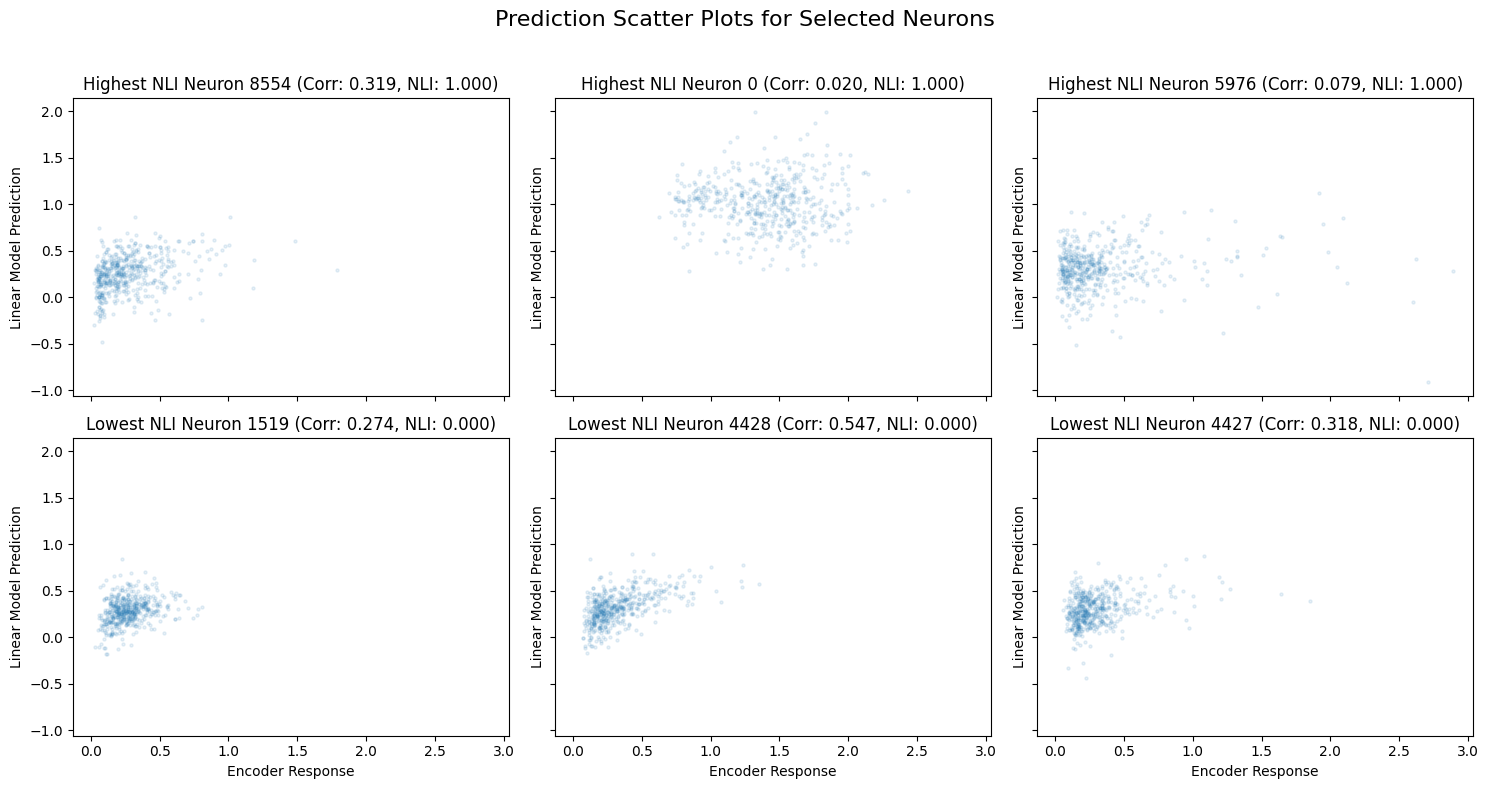

In [102]:
# --- (Optional) Step 5: Visualize a few examples ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
fig.suptitle("Prediction Scatter Plots for Selected Neurons", fontsize=16)

# Plot best neurons
for i in range(3):
    ax = axes[0, i]
    neuron_idx = top_k_indices[i]
    ax.scatter(resp_encoder_np[:, neuron_idx], resp_linear_np[:, neuron_idx], alpha=0.1, s=5)
    ax.set_title(f"Highest NLI Neuron {neuron_idx} (Corr: {per_neuron_corr[neuron_idx]:.3f}, NLI: {nli[neuron_idx]:.3f})")
    ax.set_ylabel("Linear Model Prediction")

# Plot worst neurons
for i in range(3):
    ax = axes[1, i]
    neuron_idx = bottom_k_indices[i]
    ax.scatter(resp_encoder_np[:, neuron_idx], resp_linear_np[:, neuron_idx], alpha=0.1, s=5)
    ax.set_title(f"Lowest NLI Neuron {neuron_idx} (Corr: {per_neuron_corr[neuron_idx]:.3f}, NLI: {nli[neuron_idx]:.3f})")
    ax.set_xlabel("Encoder Response")
    ax.set_ylabel("Linear Model Prediction")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()